# Karmaşık Sistemler ve Veri Bilimi Yaz Okulu - 2019

## 2. Model oluşturma ve Eğitim

**Google Colab - files access**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Kütüphaneleri yükleyelim

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

In [3]:
!ls '/content/gdrive/My Drive/KaVe19/dataset'

artists.csv  best-artworks-of-all-time.zip  images  images.zip	resized.zip


In [4]:
dataset_root_path = '/content/gdrive/My Drive/KaVe19/dataset/'
table_artists_path = dataset_root_path + 'artists.csv'

df_artists = pd.read_csv(table_artists_path)
df_artists.shape

(50, 8)

### Veri İşleme
Veri kümesi dengeli olmadığından (Van Gogh'un 877 eseri varken, Paul Gauguin'in sadece 331 eseri mevcut) '[class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html)' belirlemek eğitimin başarımını arttıran bir faktör.

**Daha iyi bir sınıflandırma için 200'ün üzerinde eseri olan 11 sanatçı seçilerek devam edeceğiz.**

In [5]:
# Sort artists by number of paintings
artists = df_artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = df_artists[df_artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,1.000000
1,Pablo Picasso,439,1.997722
2,Pierre-Auguste Renoir,336,2.610119
3,Francisco Goya,291,3.013746
4,Albrecht Dürer,328,2.673780
5,Alfred Sisley,259,3.386100
6,Marc Chagall,239,3.669456
7,Edgar Degas,702,1.249288
8,Rembrandt,262,3.347328
9,Titian,255,3.439216


In [6]:
len(artists_top)

11

Veri kümesi dengeli olmadığından '[class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html)' belirlemek eğitimin başarımını arttıran bir faktör.

In [7]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 1.0,
 1: 1.9977220956719817,
 2: 2.6101190476190474,
 3: 3.013745704467354,
 4: 2.673780487804878,
 5: 3.386100386100386,
 6: 3.6694560669456067,
 7: 1.2492877492877492,
 8: 3.3473282442748094,
 9: 3.43921568627451,
 10: 2.819935691318328}

In [0]:
# There is some problem recognizing 'Albrecht_Dürer' (don't know why, worth exploring)
# So I'll update this string as directory name to df's
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [9]:
# Explore images of top artists
images_dir = dataset_root_path + 'images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/gdrive/My Drive/KaVe19/dataset/images/Vincent_van_Gogh
Found --> /content/gdrive/My Drive/KaVe19/dataset/images/Pablo_Picasso
Found --> /content/gdrive/My Drive/KaVe19/dataset/images/Pierre-Auguste_Renoir
Found --> /content/gdrive/My Drive/KaVe19/dataset/images/Francisco_Goya
Found --> /content/gdrive/My Drive/KaVe19/dataset/images/Albrecht_Dürer
Found --> /content/gdrive/My Drive/KaVe19/dataset/images/Alfred_Sisley
Found --> /content/gdrive/My Drive/KaVe19/dataset/images/Marc_Chagall
Found --> /content/gdrive/My Drive/KaVe19/dataset/images/Edgar_Degas
Found --> /content/gdrive/My Drive/KaVe19/dataset/images/Rembrandt
Found --> /content/gdrive/My Drive/KaVe19/dataset/images/Titian
Found --> /content/gdrive/My Drive/KaVe19/dataset/images/Paul_Gauguin


### Veri kümesindeki bir kaç resmi rastgele görüntüleyelim

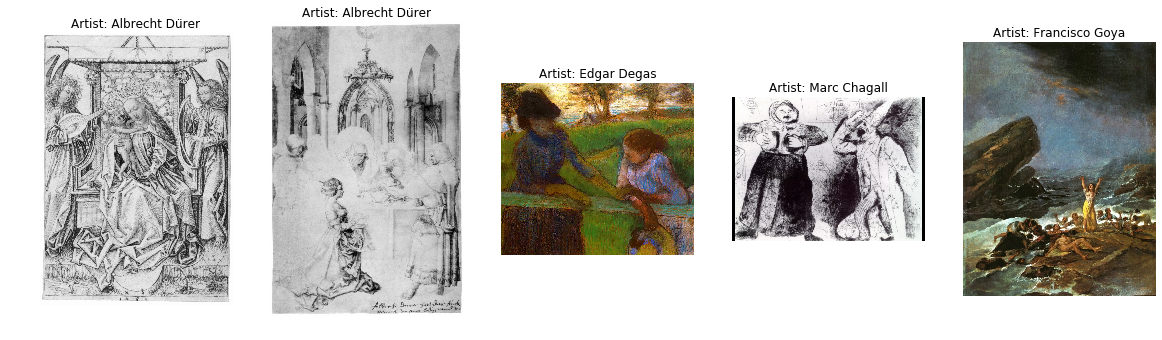

In [10]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

## Veri Arttırma
Detaylı bilgi: https://keras.io/preprocessing/image/

In [11]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 215 and 53


### Veri arttırma işlemi uygulanmış resimlerden rastgele görüntüleyelim

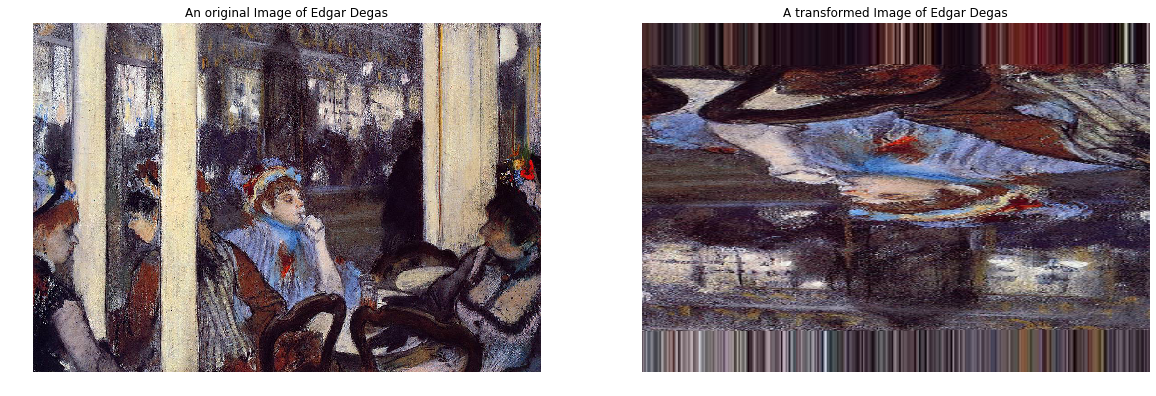

In [12]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

## Model Oluşturma

In [14]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [15]:
# Add layers at the end
X = base_model.output
#X = MaxPooling2D(2,2)(X)
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

W0718 15:01:16.270493 139686393206656 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
n_epoch = 40

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

### Eğitim

In [18]:
# Train the model - all layers
history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/40
215/215 [==============================] - 195s 905ms/step - loss: 3.8086 - acc: 0.4644 - val_loss: 2.6059 - val_acc: 0.1828
Epoch 2/40
215/215 [==============================] - 128s 596ms/step - loss: 2.9970 - acc: 0.6491 - val_loss: 4.0691 - val_acc: 0.0767
Epoch 3/40
215/215 [==============================] - 127s 590ms/step - loss: 2.7717 - acc: 0.6838 - val_loss: 3.4516 - val_acc: 0.0884
Epoch 4/40
215/215 [==============================] - 132s 613ms/step - loss: 2.6017 - acc: 0.7068 - val_loss: 2.3891 - val_acc: 0.2571
Epoch 5/40
215/215 [==============================] - 132s 613ms/step - loss: 2.4492 - acc: 0.7287 - val_loss: 1.4287 - val_acc: 0.5967
Epoch 6/40
215/215 [==============================] - 137s 637ms/step - loss: 2.2998 - acc: 0.7401 - val_loss: 1.1607 - val_acc: 0.6840
Epoch 7/40
215/215 [==============================] - 138s 642ms/step - loss: 2.1142 - acc: 0.7690 - val_loss: 1.1253 - val_acc: 0.7040
Epoch 8/40
215/215 [============================

**Eğitim aşamasındaki değerleri dosyaya kaydedelim**

In [0]:
!mkdir '/content/gdrive/My Drive/KaVe19/models/'

with open('/content/gdrive/My Drive/KaVe19/models/trainHistoryDict_40.pkl', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

**Modeli ve eğitilmiş ağırlık dosyalarını kaydedelim**

In [19]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('/content/gdrive/My Drive/KaVe19/models/my_model.h5')


Using TensorFlow backend.


In [20]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/gdrive/My Drive/KaVe19/models/model_40.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/KaVe19/models/model_40.h5")
print("Saved model to disk")

Saved model to disk


## Eğitim Doğruluk/Kayıp Değerleri ile Doğrulama Veri Kümesi için Doğruluk/Kayıp Değerlerini Çizdirelim

Epoch - 40

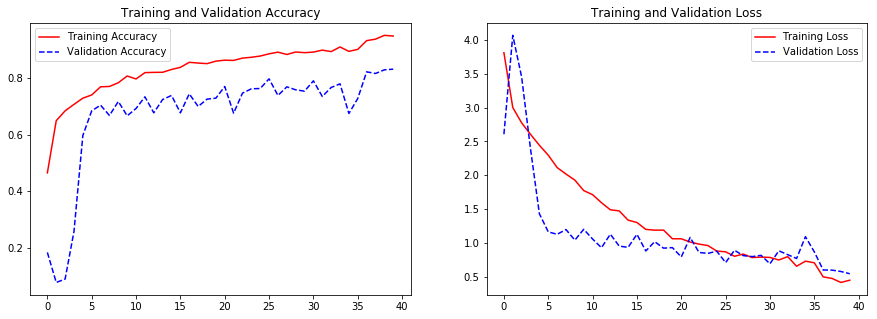

In [21]:
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history.history)

## Modelin Performansını Ölçelim

Epoch - 40

In [22]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator)
print("Prediction accuracy on train data =", score[1])

Prediction accuracy on train data = 0.98373985


In [23]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator)
print("Prediction accuracy on CV data =", score[1])

Prediction accuracy on CV data = 0.8292398


### Confusion Matrix'i hesaplayarak, eğitilen modelin hangi sanatçının eserlerinin ne kadar ayırt edebiliyor, hangi sanatçının eserlerine benzetip karıştırıyor, inceleyelim

Epoch - 40


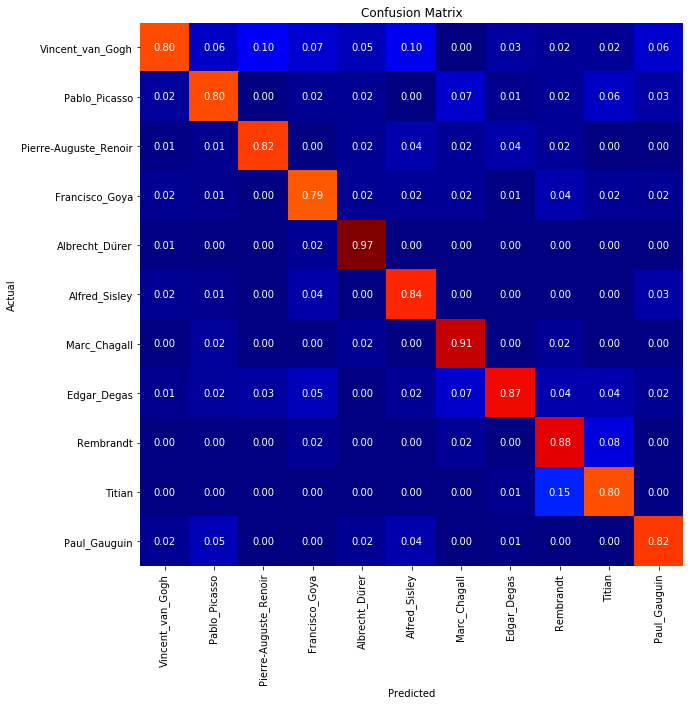

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.89      0.80      0.85       174
        Pablo_Picasso       0.81      0.80      0.81        86
Pierre-Auguste_Renoir       0.86      0.82      0.84        67
       Francisco_Goya       0.79      0.79      0.79        57
      Albrecht_Dürer       0.89      0.97      0.93        64
        Alfred_Sisley       0.80      0.84      0.82        51
         Marc_Chagall       0.82      0.91      0.86        45
          Edgar_Degas       0.89      0.87      0.88       140
            Rembrandt       0.74      0.88      0.81        52
               Titian       0.78      0.80      0.79        50
         Paul_Gauguin       0.84      0.82      0.83        62

             accuracy                           0.84       848
            macro avg       0.83      0.85      0.84       848
         weighted avg       0.84      0.84      0.84       848



In [24]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

### Veri kümesinin rastgele resimler üzerinde tahmin performansını değerlendirelim

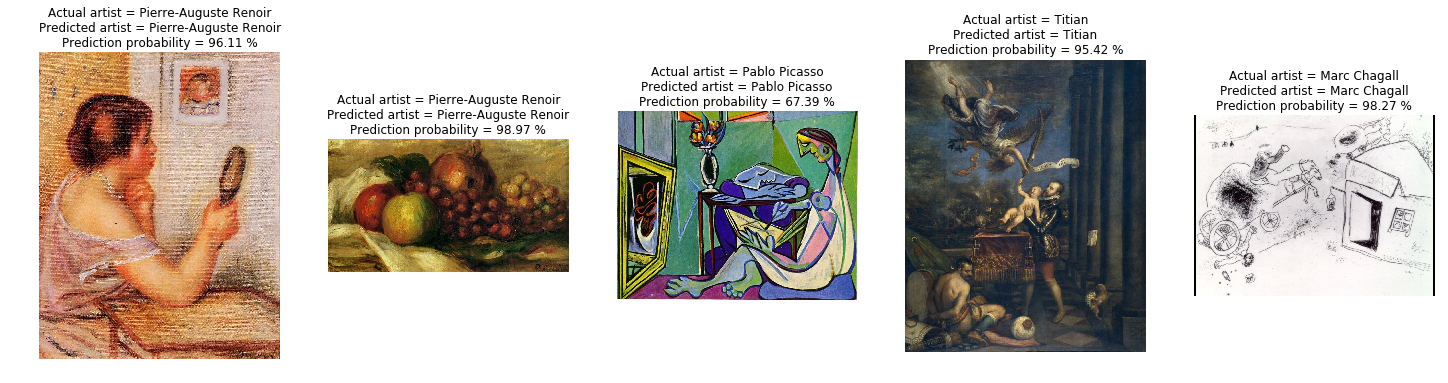

In [25]:
# Prediction
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image
    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())


    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

## Web URL Test

http://www.4-construction.com/up/images/featured/art/03-jacqueline-at-the-studio-1956.jpg
Predicted artist = Pablo Picasso
Prediction probability = 92.62005686759949 %


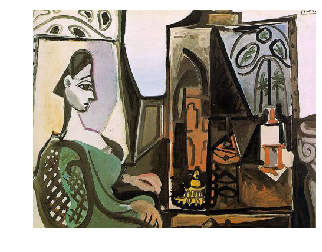

In [26]:
# Predict from web - this is an image of Titian.
# Replace 'url' with any image of one of the 11 artists above and run this cell.

url = 'http://www.4-construction.com/up/images/featured/art/03-jacqueline-at-the-studio-1956.jpg' #@param {type:"string"}

print(url)

import imageio
import cv2

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()